# **Orientation Filtering**

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from test_image import get_test_image

![](assets/oriented_energy.png)

In [14]:
def gaussian2(x, y, a=1, mu_x=0, mu_y=0, sig_x=1, sig_y=1):
    """ 2D Gaussian Window Function
        Inputs:
            x - horizontal location argument
            y - vertical location argument
            a - scalar amplitude 
            mu_x - x (horizontal) mean (controls horizontal center)
            mu_y - y (vertical) mean (controls vertical center)
            sig_x - x (horizontal) standard deviation (controls horizontal spread)
            sig_y - y (vertical) standard deviation (controls vertical spread)
        Outputs:
            output 2D Gaussian Function Response at x, y
        """
    return a*np.exp(- ((x - mu_x)**2)/(sig_x**2) - ((y - mu_y)**2)/(sig_y**2) )



# def get_orientation_coeffs(x, y):
#     """ Obtains the first 3 Orientation Coefficients that comprise 
#         the Orientation Energy E = G**2 + H**2

#         """
#     # get circularly symmetric window
#     window = np.exp(-(x**2 + y**2))
    
#     # obtain even filter coefficients
#     g2a = 0.9213*(2*(x**2) - 1)*window
#     g2b = 1.843*x*y*window
#     g2c = 0.9213*(2*(y**2) - 1)*window

#     # obtain odd filter coefficients
#     h2a = 0.9780*(-2.254*x + (x**3))*window
#     h2b = 0.9780*(-0.7515 + (x**2))*y*window
#     h2c = 0.9780*(-0.7515 + (y**2))*x*window
#     h2d = 0.9780*(-2.254*y + (y**3))*window

#     # compute Orientation Energy Coefficients
#     C1 = 0.5*(g2b**2) + 0.25*g2a*g2c + 0.375*(g2a**2 + g2c**2) + 0.3125*(h2a**2 + h2d**2) + 0.5625*(h2b**2 + h2c**2) + 0.375*(h2a*h2c + h2b*h2d)
#     C2 = 0.5*(g2a**2 - g2c**2) + 0.46875*(h2a**2 - h2d**2) + 0.28125*(h2b**2 - h2c**2) + 0.1875*h2a*h2c - h2b*h2d
#     C3 = -(g2a*g2b) - (g2b*g2c) - 0.9375*(h2c*h2d + h2a*h2b) - 1.6875*h2b*h2c - 0.1875*h2a*h2d

#     return C1, C2, C3



def get_orientation_coeffs(x, y, image):
    """ Obtains the first 3 Orientation Coefficients that comprise 
        the Orientation Energy E = G**2 + H**2

        """
    # get circularly symmetric window
    window = np.exp(-(x**2 + y**2))
    
    # obtain even filter coefficients
    g2a = 0.9213*(2*(x**2) - 1)*window
    g2b = 1.843*x*y*window
    g2c = 0.9213*(2*(y**2) - 1)*window

    # obtain odd filter coefficients
    h2a = 0.9780*(-2.254*x + (x**3))*window
    h2b = 0.9780*(-0.7515 + (x**2))*y*window
    h2c = 0.9780*(-0.7515 + (y**2))*x*window
    h2d = 0.9780*(-2.254*y + (y**3))*window

    # reshape 
    n = np.sqrt(x.shape[0]).astype(int)

    g2a = g2a.reshape((n, n))
    g2b = g2b.reshape((n, n))
    g2c = g2c.reshape((n, n))
    h2a = h2a.reshape((n, n))
    h2b = h2b.reshape((n, n))
    h2c = h2c.reshape((n, n))
    h2d = h2d.reshape((n, n))

    # get basis filter outputs
    g2a = cv2.filter2D(image, ddepth=-1, kernel=g2a)
    g2b = cv2.filter2D(image, ddepth=-1, kernel=g2b)
    g2c = cv2.filter2D(image, ddepth=-1, kernel=g2c)

    h2a = cv2.filter2D(image, ddepth=-1, kernel=h2a)
    h2b = cv2.filter2D(image, ddepth=-1, kernel=h2b)
    h2c = cv2.filter2D(image, ddepth=-1, kernel=h2c)
    h2d = cv2.filter2D(image, ddepth=-1, kernel=h2d)

    # compute Orientation Energy Coefficients
    C1 = 0.5*(g2b**2) + 0.25*g2a*g2c + 0.375*(g2a**2 + g2c**2) + 0.3125*(h2a**2 + h2d**2) + 0.5625*(h2b**2 + h2c**2) + 0.375*(h2a*h2c + h2b*h2d)
    C2 = 0.5*(g2a**2 - g2c**2) + 0.46875*(h2a**2 - h2d**2) + 0.28125*(h2b**2 - h2c**2) + 0.1875*h2a*h2c - h2b*h2d
    C3 = -(g2a*g2b) - (g2b*g2c) - 0.9375*(h2c*h2d + h2a*h2b) - 1.6875*h2b*h2c - 0.1875*h2a*h2d

    return C1, C2, C3

In [58]:
def even_filter(x, y, theta, a=1, mu_x=0, mu_y=0, sig_x=1, sig_y=1):
    """ 2nd Gaussian Derivative Steerable Even Filter G2
        Constructed by passing (Nx1) vectors tap indexes (x,y) locations 
        of desired filter. 
        Only valid for default 2D Gaussian Arguments.
        Inputs:
            x - (Nx1) horizontal location argument
            y - (Nx1) vertical location argument
            theta - steering angle in radians
        Outputs:
            filter value at (x,y) coordinates
    """
    window = gaussian2(x, y, a, mu_x, mu_y, sig_x, sig_y)

    g2a = 0.9213*(2*(x**2) - 1)*window
    g2b = 1.843*x*y*window
    g2c = 0.9213*(2*(y**2) - 1)*window

    ka = np.cos(theta)**2
    kb = -2*np.cos(theta)*np.sin(theta) 
    kc = np.sin(theta)**2

    return ka*g2a + kb*g2b + kc*g2c


def odd_filter(x, y, theta, a=1, mu_x=0, mu_y=0, sig_x=1, sig_y=1):
    """ 2nd Gaussian Derivative Steerable Odd Filter H2
        Constructed by passing (Nx1) vectors tap indexes (x,y) locations 
        of desired filter. Tap indexes correspond to offsets in either direction
        Only valid for default 2D Gaussian Arguments.
        Inputs:
            x - (Nx1) horizontal location argument
            y - (Nx1) vertical location argument
            theta - steering angle in radians
        Outputs:
            filter value at (x,y) coordinates
    """
    window = gaussian2(x, y, a, mu_x, mu_y, sig_x, sig_y)

    h2a = 0.9780*(-2.254*x + (x**3))*window
    h2b = 0.9780*(-0.7515 + (x**2))*y*window
    h2c = 0.9780*(-0.7515 + (y**2))*x*window
    h2d = 0.9780*(-2.254*y + (y**3))*window

    ka = np.cos(theta)**3
    kb = -3*(np.cos(theta)**2)*np.sin(theta)
    kc = 3*np.cos(theta)*(np.sin(theta)**2)
    kd = -(np.sin(theta)**3)

    return ka*h2a + kb*h2b + kc*h2c + kc*h2c + kd*h2d


In [15]:
def get_xy(m, s=1):
    """ Obtains x and y indexes for desired number of filter taps 
        Inputs:
            m - number of taps (1 sided)
            s - spacing
        Outputs:
            x_indexes, y_indexes - column vectors of x and y indexes    
    """
    range_index = np.arange(-(m+s), (m+s) + s, s)
    x_index, y_index = np.meshgrid(range_index, range_index)
    x_index = x_index.reshape((-1, 1))
    y_index = y_index.reshape((-1, 1))

    return x_index, y_index

In [61]:
m = 4 # number of taps
s = 0.67 # spacing
# theta = 0 # np.pi/4 # steering angle in radians

x_index, y_index = get_xy(m=m, s=s)
# n = np.sqrt(x_index.shape[0]).astype(int)
# C1, C2, C3 = get_orientation_coeffs(x_index, y_index)

In [220]:
from skimage.data import camera

test_image = camera()

# get complex test image
test_image = get_test_image(512).astype(np.float32)

# 0-1 normalize
test_image = cv2.normalize(test_image, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32FC1)

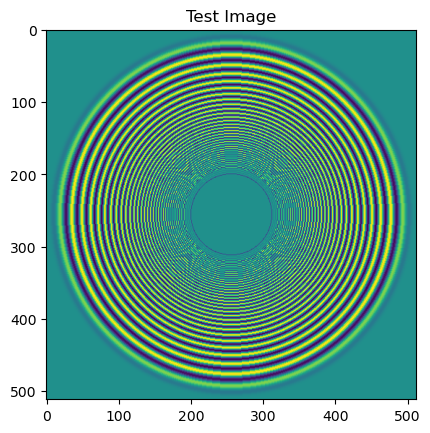

In [221]:
plt.imshow(test_image)
plt.title("Test Image");

In [222]:
C1, C2, C3 = get_orientation_coeffs(x_index, y_index, test_image)

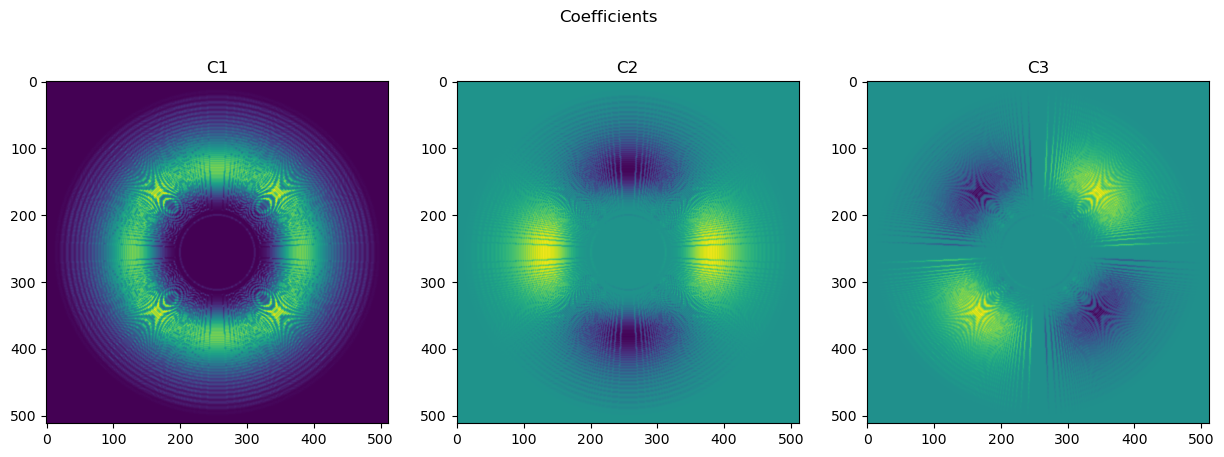

In [223]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f"Coefficients")
ax[0].imshow(C1)
ax[0].set_title("C1")
ax[1].imshow(C2)
ax[1].set_title("C2"); 
ax[2].imshow(C3)
ax[2].set_title("C3"); 

In [224]:
angle = np.arctan(C2, C3)/2
mag = np.sqrt(C2**2 + C3**2)

In [225]:
np.cos(angle), np.sin(angle)

(array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]], dtype=float32),
 array([[4.8000057e-17, 4.8000057e-17, 4.8000057e-17, ..., 4.8000057e-17,
         4.8000057e-17, 4.8000057e-17],
        [4.8000057e-17, 4.8000057e-17, 4.8000057e-17, ..., 4.8000057e-17,
         4.8000057e-17, 4.8000057e-17],
        [4.8000060e-17, 4.8000060e-17, 4.8000060e-17, ..., 4.8000057e-17,
         4.8000057e-17, 4.8000057e-17],
        ...,
        [4.8000057e-17, 4.8000057e-17, 4.8000057e-17, ..., 4.8000057e-17,
         4.8000057e-17, 4.8000057e-17],
        [4.8000057e-17, 4.8000057e-17, 4.8000057e-17, ..., 4.8000057e-17,
         4.8000057e-17, 4.8000057e-17],
        [4.8000057e-17, 4.8000057e-17, 4.8000057e-17, ..., 4.8000057e-17,
         4.8000057e-17, 4.8000057e-17]], dtype=float32))

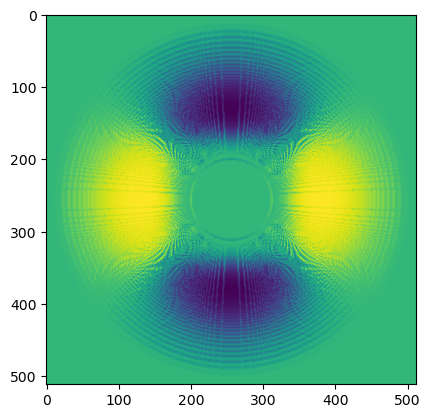

In [226]:
plt.imshow((np.cos(angle) + np.sin(angle)))

In [227]:
angle.shape

(512, 512)

In [228]:
angle.min(), angle.max()

(-0.6230859, 0.6137967)

In [229]:
np.degrees(angle.mean())

-1.1640791

In [230]:
np.degrees(angle[256, 400])

32.173073

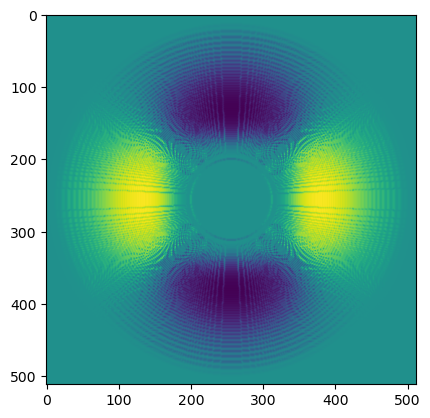

In [231]:
plt.imshow(angle)

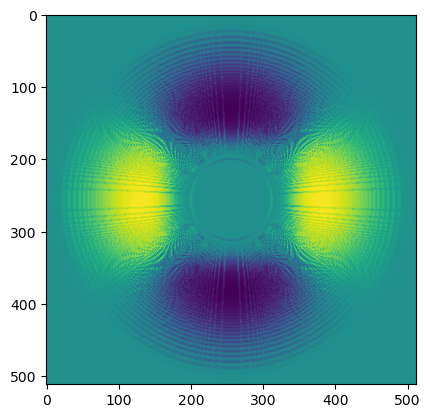

In [232]:
plt.imshow(np.sin(angle))

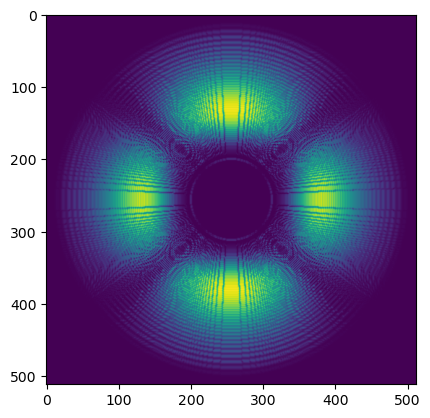

In [233]:
plt.imshow(mag)

In [234]:
n = np.sqrt(x_index.shape[0]).astype(int)
G2 = even_filter(x_index, y_index, theta=angle.mean()).reshape((n, n))
H2 = odd_filter(x_index, y_index, theta=angle.mean()).reshape((n, n))

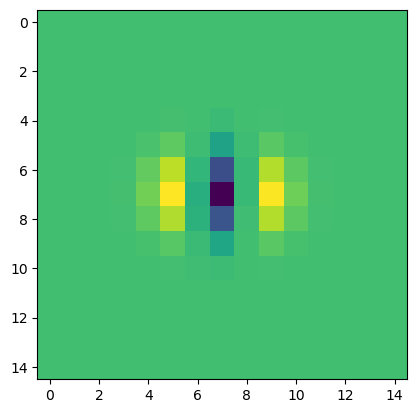

In [235]:
plt.imshow(G2)

In [236]:
samples = np.zeros(test_image.shape, dtype=bool)
samples[0:-1:24, 0:-1:24] = 1

In [237]:
# np.cos(angle[samples]), np.sin(angle[samples])
mag[samples].max()

3.176123

In [238]:
img_rows, img_cols = test_image.shape

In [239]:
orientations = np.zeros_like(test_image)
for i in range(12, img_rows, 12):
    for j in range(12, img_cols, 12):
        # print(i,j, angle[i,j], np.cos(angle[i,j]), np.sin(angle[i,j]))
        start_point = (j, i)
        end_point = (j + 2*np.round(mag[i,j] * np.sin(angle[i,j])).astype(int),
                     i + 2*np.round(mag[i,j] * np.cos(angle[i,j])).astype(int))
        cv2.line(orientations, start_point, end_point, (255,), 1)

In [240]:
print(i,j, angle[i,j], np.cos(angle[i,j]), np.sin(angle[i,j]))

504 504 4.8000057e-17 1.0 4.8000057e-17


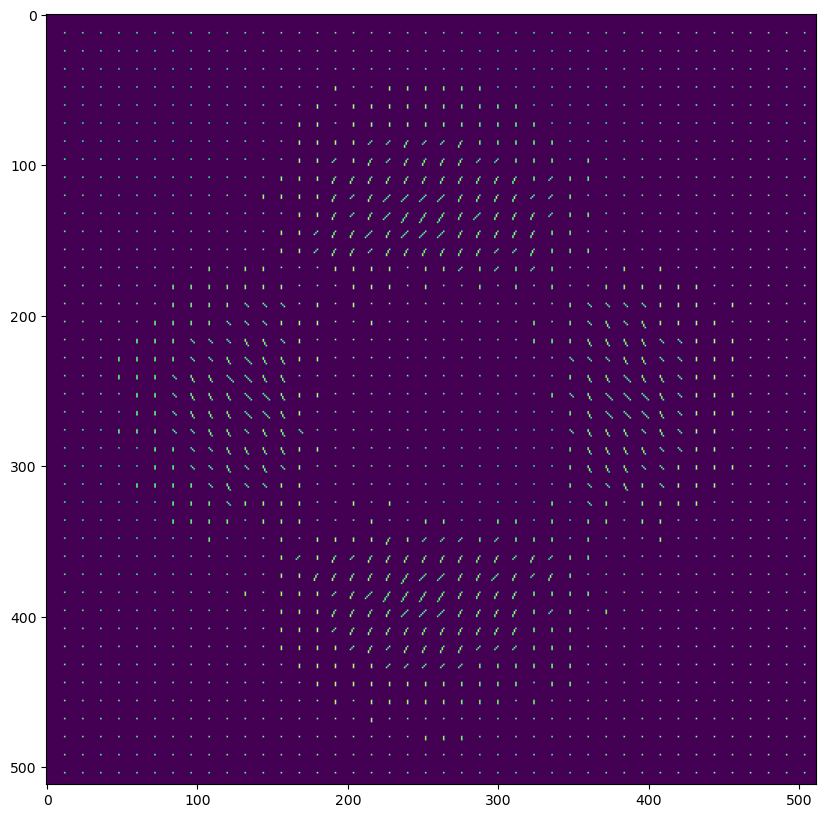

In [241]:
plt.figure(figsize=(10, 10))
plt.imshow(orientations)